In [1]:
import pytorch_lightning as pl
import torch 
from pytorch_lightning.metrics.functional.classification import accuracy
from tqdm import tqdm
from src import DataModule, Resnet
import torchvision
import pandas as pd 
from pathlib import Path
from skimage import io

In [15]:
model = Resnet.load_from_checkpoint(checkpoint_path='./resnet18-256-da-val_acc=0.81172.ckpt')
model.hparams

"backbone":    resnet18
"batch_size":  256
"extra_data":  1
"lr":          0.0003
"max_epochs":  50
"optimizer":   Adam
"precision":   16
"seed":        42
"size":        256
"subset":      0.1
"test_size":   0.2
"train_trans": {'RandomCrop': {'size': 256}, 'RandomHorizontalFlip': {}, 'RandomVerticalFlip': {}}
"tta_rounds":  0
"tta_trans":   {'RandomResizedCrop': {'size': 256}, 'RandomHorizontalFlip': {}, 'RandomVerticalFlip': {}}
"val_batches": 10
"val_trans":   {'CenterCrop': {'size': 256}}

In [17]:
dm = DataModule(
    val_trans={
        'CenterCrop': {
            'height': 256,
            'width': 256
        }
    }
)

dm.setup()

Training samples:  21642
Validation samples:  5411


In [18]:
 def evaluate(model, dl):   
    model.eval()
    model.cuda()
    acc = []
    with torch.no_grad():
        t = tqdm(dl)
        for x, y in t:
            x, y = x.cuda(), y.cuda()
            y_hat = model(x)
            acc.append(accuracy(y_hat, y).item())
            t.set_description(f"acc {np.mean(acc):.5f}")
            
evaluate(model, dm.val_dataloader())

acc 0.79777: 100%|█████████████████████████████████| 85/85 [00:55<00:00,  1.54it/s]


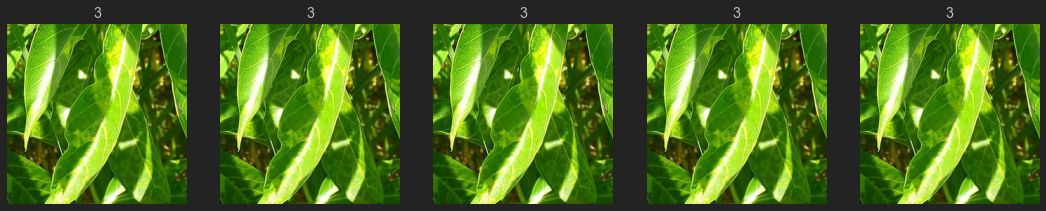

In [19]:
import random

def plot_imgs():
    r, c = 1, 5
    fig = plt.figure(figsize=(3*c, 3*r))
    ds = dm.val_ds
    ix = random.randint(0, len(ds)-1)
    for _r in range(r):
        for _c in range(c):
            ax = plt.subplot(r, c, _r*c + _c + 1)
            img, label = ds[ix]
            plt.axis("off")
            plt.imshow(img.permute(1,2,0))
            plt.title(label.item())
    plt.tight_layout()
    plt.show()
    
plot_imgs()

In [20]:
def evaluate_tta(model, ds, tta = 0, limit = 1):   
    model.eval()
    model.cuda()
    acc = []
    with torch.no_grad():
        t = tqdm(range(len(ds)))
        for ix in t:
            y = ds[ix][1].unsqueeze(0).cuda()
            imgs = torch.stack([ds[ix][0] for i in range(tta+1)]).cuda()
            y_hat = model(imgs).mean(axis=0).unsqueeze(0)
            acc.append(accuracy(y_hat, y).item())
            t.set_description(f"acc {np.mean(acc):.5f}")
            if ix >= int(limit*len(ds)):
                break
            
evaluate_tta(model, dm.val_ds, limit=0.1)

acc 0.82103:  10%|██▉                           | 541/5411 [00:15<02:18, 35.08it/s]


In [21]:
dm = DataModule(
    val_trans={
        'RandomCrop': {
            'height': 256,
            'width': 256
        }
    }
)

dm.setup()

Training samples:  21642
Validation samples:  5411


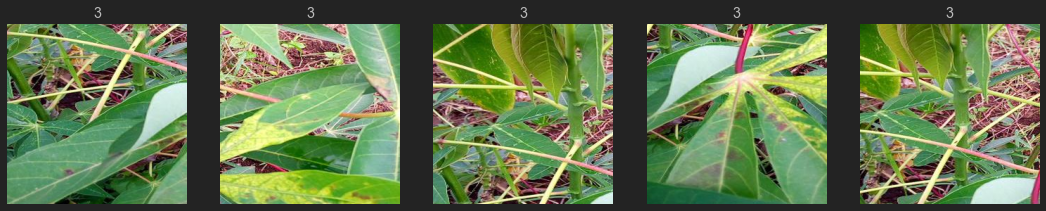

In [22]:
plot_imgs()

In [23]:
evaluate_tta(model, dm.val_ds, tta = 10, limit=0.1)

acc 0.83026:  10%|██▉                           | 541/5411 [01:02<09:21,  8.67it/s]


In [24]:
dm = DataModule(
    val_trans={
        'RandomCrop': {
            'height': 256,
            'width': 256
        },
        'HorizontalFlip': {},
        'VerticalFlip': {}
    }
)

dm.setup()

Training samples:  21642
Validation samples:  5411


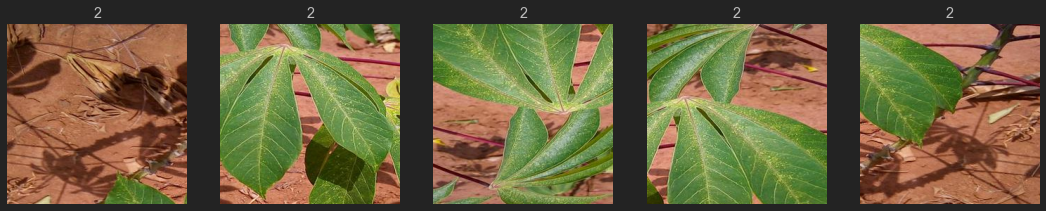

In [25]:
plot_imgs()

In [26]:
evaluate_tta(model, dm.val_ds, tta = 10, limit=0.1)

acc 0.83026:  10%|██▉                           | 541/5411 [01:02<09:23,  8.65it/s]


In [27]:
class FinalModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.trans = torch.nn.Sequential(
            torchvision.transforms.RandomCrop(256),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip()
        )
    
    def forward(self, x, tta : int = 1):
        x = x.float() / 255.
        x = x.permute(2, 0, 1)
        imgs = torch.stack([self.trans(x) for i in range(tta)])
        y_hat = self.model(imgs).mean(dim=0)
        return torch.argmax(y_hat)

In [28]:
final_model = FinalModel(model.resnet.cpu())

In [29]:
def evaluate_tta_script(model, ds, tta = 1, limit = 1.):   
    model.eval()
    model.cuda()
    acc = []
    with torch.no_grad():
        t = tqdm(range(len(ds)))
        for ix in t:
            x, y = ds[ix]
            x, y = x.cuda(), y.cuda()
            # simulate test
            x *= 255. 
            x = x.permute(1, 2, 0).long()
            #print(x.shape, x.dtype, x.max(), x.min())
            y_hat= model(x, tta)
            acc.append((y_hat == y).item())
            t.set_description(f"acc {np.mean(acc):.5f}")
            
            if ix >= int(limit*len(ds)):
                break

In [30]:
dm = DataModule(
    val_trans= None
)

dm.setup()

Training samples:  21642
Validation samples:  5411


In [31]:
evaluate_tta_script(final_model, dm.val_ds, tta = 10, limit = 0.1)

acc 0.83210:  10%|██▉                           | 541/5411 [00:17<02:33, 31.70it/s]


In [33]:
script = torch.jit.script(final_model.cpu())

torch.jit.save(script, "model.pt")

In [34]:
loaded = torch.jit.load('model.pt')

evaluate_tta_script(loaded, dm.val_ds, tta = 50, limit = 0.1)

acc 0.83579:  10%|██▉                           | 541/5411 [00:59<08:58,  9.05it/s]


In [35]:
path = Path('./data/test_images')
images = os.listdir(path)
images_paths = [str(path/img) for img in images]
len(images)

1

In [37]:
def predict(model, imgs, tta = 1):   
    model.eval()
    preds = []
    with torch.no_grad():
        for img in imgs:
            img = torch.from_numpy(io.imread(img))
            y_hat = model(img, tta)
            preds.append(y_hat.item())
    return preds

In [38]:
loaded = torch.jit.load('model.pt')
preds = predict(loaded, images_paths, tta = 10)
preds

[2]

In [39]:
submission = pd.DataFrame({'image_id': images, 'label': preds })
submission

,image_id,label
0,2216849948.jpg,2


In [40]:
submission.to_csv('submission.csv', index=False)